In [4]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist

from mesa import Model, Agent
from mesa.time import BaseScheduler
from mesa.space import ContinuousSpace
from mesa.datacollection import DataCollector


class Count:
    """Helper class for creating unique ids for agents"""

    def __init__(self):
        self.count = 0

    def __call__(self):
        self.count += 1

        return self.count
count = Count()


def plurality_vote(population, candidates, parties):
    # calculate distances to all candidates
    distances = cdist(population, candidates)

    # depending on vote scheme determine who wins
    winners = np.argmin(distances, axis=1)
    unique, counts = np.unique(winners, return_counts=True)

    votes_per_party = np.zeros(len(parties))
    for party_id, votes in zip(unique, counts):
        votes_per_party[party_id] = votes

    winning_party_index = unique[counts.argmax()]
    return parties[winning_party_index], votes_per_party


def borda_count(population, candidates, parties):
    # calculate distances to all candidates
    distances = cdist(population, candidates)
    
    # handles ties poorly but is order of magnitude faster
    rank = np.argsort(
        np.argsort(distances, axis=1), axis=1
    )  
    # rank = sp.stats.rankdata(distances, method='min', axis=1) # as per olympics
    scores = rank.sum(axis=0)
    winning_party_index = np.argmin(scores)
    return parties[winning_party_index], scores


def majority_vote(population, candidates, parties):
    distances = cdist(population, candidates)
    parties = np.asarray(parties)

    # vote share in first round
    winners = np.argmin(distances, axis=1)
    unique, counts = np.unique(winners, return_counts=True)

    votes_per_party = np.zeros(len(parties))
    for party_id, votes in zip(unique, counts):
        votes_per_party[party_id] = votes

    # determine the actual winner
    while True:
        ranking = np.argsort(np.argsort(distances, axis=1))
        counts = np.sum(ranking == 0, axis=0)

        if np.any(counts >= 0.5 * population.shape[0]):
            return parties[counts.argmax()], votes_per_party
        else:
            # crude way of avoiding ties
            remaining_candidates = np.ones(parties.shape, dtype=bool)
            remaining_candidates[np.argmin(counts)] = False
            distances = distances[:, remaining_candidates]
            parties = parties[remaining_candidates]


class VotingModel(Model):
    """Voting model class

    Parameters
    ----------
    n_districts : int
    n_parties : int
    seed : int, optional
    vote_system : callable, optional

    Note that the entire implementation is based on numpy rather than pandas. The
    pure numpy implementation is more then an order of magnitude faster than an
    equivalent pandas implementation.

    """

    @property
    def parties(self):
        return self.party_scheduler.agents

    @property
    def districts(self):
        return self.district_scheduler.agents

    def __init__(self, n_districts, n_parties, seed=None, vote_system=plurality_vote):
        super().__init__(seed=seed)
        self.np_random = np.random.default_rng(seed)
        self.n_districts = n_districts
        self.n_parties = n_parties

        self.space = ContinuousSpace(x_min=-2, x_max=2, y_min=-2, y_max=2, torus=False)
        self.district_scheduler = BaseScheduler(self)
        self.party_scheduler = BaseScheduler(self)

        # sub population policy profile means
        # hard coded assumption of 3 sub populations
        self.profiles = np.asarray([[0.25, 0.25], [0.50, 0.75], [0.8, 0.33]])

        # district are heterogeneous with respect to how large each subpopulation is
        district_compositions = self.np_random.random(
            size=(n_districts, self.profiles.shape[0])
        )
        district_compositions = (
            district_compositions / np.sum(district_compositions, axis=1)[:, np.newaxis]
        )

        # create districts
        for i, composition in enumerate(district_compositions):
            district = District(count(), self, composition, i, vote_system=vote_system)
            self.district_scheduler.add(district)

        # create parties
        for i in range(n_parties):
            profile = self.random.choices(self.profiles)
            position = self.np_random.normal(profile, (0.15,) * 2, size=(1, 2))[0]
            party = Party(count(), self, position, i, n_districts)
            self.party_scheduler.add(party)

        self.seats = np.zeros((n_parties,))
        self.datacollector = DataCollector(
            agent_reporters={
                "x": "x",
                "y": "y",
                "seats": "seats",
                "voteshare": "voteshare",
            },
        )
        self.election_results = np.zeros(self.n_districts, dtype=object)
        self.votes_per_district = np.zeros(
            (self.n_districts, self.n_parties),
        )
        self.voteshare = np.zeros((self.n_districts,))
        self.schedule = self.party_scheduler # hack to only gather agent reporters for parties

    def get_population(self):
        return np.concatenate([d.population for d in self.districts], axis=0)

    def step(self):
        """
        Run one step of the model.
        """
        # let districts vote
        self.district_scheduler.step()

        # update model level attributes
        self.voteshare = (
            self.votes_per_district.sum(axis=0) / self.votes_per_district.sum()
        )

        # let parties update their policy position
        self.party_scheduler.step()

        self.datacollector.collect(self)


class District(Agent):
    """District agent

    Parameters
    ----------
    unique_id : int
    model : VotingModel instance
    composition : tuple
    i_district : int
                 index of this district in model.election_results,
                 model.votes_per_district, and party.candidates
    vote_system : callable, option


    i_district is used as part of the numpy implementation

    """

    std = [0.1, 0.1]
    population_size = 100

    def __init__(
        self, unique_id, model, composition, i_district, vote_system=plurality_vote):
        super().__init__(unique_id, model)
        self.np_random = self.model.np_random
        self.composition = composition
        self.vote = vote_system
        self.elected_party = None
        self.i_district = i_district

        # setup voters
        n_per_subpopulation = np.round(self.composition * self.population_size).astype(int)

        voters = []
        for n, profile in zip(n_per_subpopulation, model.profiles):
            voters.append(self.np_random.normal(profile, self.std, size=(n, 2)))
        self.population = np.concatenate(voters, axis=0)

    def step(self):
        parties, candidates = zip(
            *[
                (party, party.get_candidate_for_district(self.i_district))
                for party in self.model.parties
            ]
        )
        candidates = np.asarray(candidates)

        winning_party, votes_per_party = self.vote(self.population, candidates, parties)
        self.model.election_results[self.i_district] = winning_party
        self.model.votes_per_district[self.i_district, :] = votes_per_party


class Party(Agent):
    """Party agent

    Parameters
    ----------
    unique_id : int
    model : VotingModel instance
    policy_position : 2 tuple
    i_party : int
              index of party in global attributes
    n_districts : int
                  number of districts


    """

    std = [0.025, 0.025]  # std for policy position of candidates

    @property
    def x(self):
        return self.pos[0]

    @property
    def y(self):
        return self.pos[1]

    @property
    def seats(self):
        return self._seats

    @seats.setter
    def seats(self, value):
        self._seats = value

    def __init__(self, unique_id, model, policy_position, i_party, n_districts):
        super().__init__(unique_id, model)
        self.np_random = self.model.np_random
        self.model.space.place_agent(self, policy_position)
        self.i_party = i_party
        self.candidates = self.np_random.normal(
            self.pos, self.std, size=(n_districts, 2)
        )
        self.seats = 0
        self.seat_change = 0

    def get_candidate_for_district(self, i_district):
        return self.candidates[i_district, :]

    def get_election_results(self):
        self.election_results = self.model.election_results
        n_seats = np.sum(self.election_results == self)

        self.seat_change = n_seats - self.seats
        self.seats = n_seats
        self.voteshare = self.model.voteshare[self.i_party]

    def step(self):
        # I need to know where I have won and lost
        self.get_election_results()
        
        # we can use boolean indexing 
        # https://numpy.org/doc/stable/user/basics.indexing.html#boolean-array-indexing
        lost = (self.election_results != self)

        # generate new candidates for lost districts
        self.candidates[lost] = self.np_random.normal(
            self.pos, self.std, size=(lost.sum(), 2)
        )



In [5]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def plot_single_run(model):
    agent_data = model.datacollector.get_agent_vars_dataframe()
    pop = model.get_population()
    
    sns.set_style('white')

    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(2,4, figure=fig)

    ax1 = fig.add_subplot(gs[:, 0:2]) # policy space
    ax1.set_xlim(xmin=-0.25, xmax=1.25)
    ax1.set_ylim(ymin=-0.25, ymax=1.25)

    ax2 = fig.add_subplot(gs[0, 2:]) # number of seats
    ax3 = fig.add_subplot(gs[1, 2:]) # share of the overal vote

    # calculating the kde is expensive, so comment this out for speed reasons
    sns.kdeplot(x=pop[:, 0], y=pop[:, 1], ax=ax1)
    for c, (_, party_data) in zip(sns.color_palette(), agent_data.groupby('AgentID')):
        x = party_data.x.values
        y = party_data.y.values
    
        ax1.plot(x, y, c=c )
        ax1.scatter(x[-1], y[-1], color=c)
        ax2.plot(party_data.seats.values, c=c)
        ax3.plot(party_data.voteshare.values, c=c)
        
    ax1.set_title('policy space')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2.set_ylabel('seats won')
    ax2.set_xlabel('ticks')

    ax3.set_ylabel('vote share')
    ax3.set_xlabel('ticks')
    ax3.set_ylim(ymin=0, ymax=1)
    
    # create a custom figure level legend
    handles = [Line2D([0,0], [1,1], c=c) for _, c in zip(model.parties, sns.color_palette())]
    labels = [f'party {i}' for i in range(len(model.parties))]
    fig.legend(handles, labels, bbox_to_anchor=[1.1, 1])
    
    for ax in [ax2, ax3]:
        sns.despine(ax=ax)


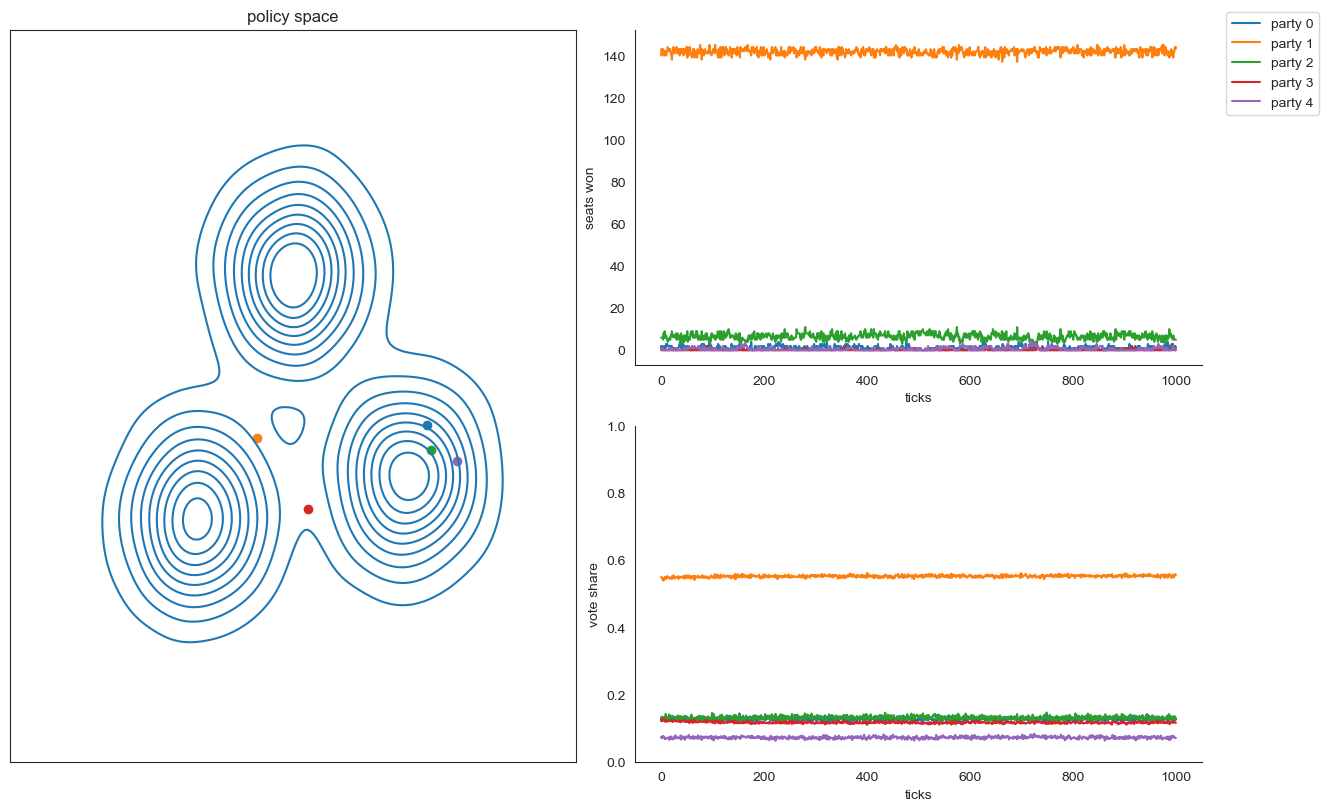

In [6]:
seed = 15
model = VotingModel(n_districts=150, n_parties=5, seed=seed, vote_system=plurality_vote)
for _ in range(1000):
    model.step()
plot_single_run(model)